In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")

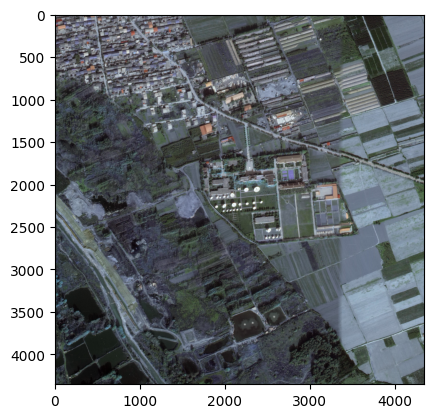

In [74]:
path = '/home/ha/Downloads/Files/Xian_station-CN_GoogleSat_v0.tif'
img = cv2.imread(path)
# cv2.imshow(img, 'nothing')
plt.figure()
plt.imshow(img)


In [75]:
class Point:
    def __init__(self, x, y, z):
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)
    def vect(self, other):
        return Vect3D(np.array([other.x - self.x,other.y - self.y,other.z - self.z]))
    def __repr__(self):
        return f'Point({self.x, self.y, self.z})'

In [76]:

class Vect3D:
    def __init__(self, arr):        
        self.values = arr
    def __abs__(self):
        return math.sqrt(np.dot(self.values, self.values))
    def __repr__(self):
        return f'Vect3D{self.values[0], self.values[1], self.values[2]}'
    def cos(self, other):
        return np.dot(self.values, other.values)/(abs(self)*abs(other))
    def __add__(self, other):
        return Vect3D(self.values + other.values)
    def __mul__(self, alpha):
        if isinstance(alpha, (int, float)):
            return Vect3D(self.values * alpha)
        elif isinstance(alpha, Vect3D):
            return np.dot(self.values, alpha.values)
        else: return NotImplemented

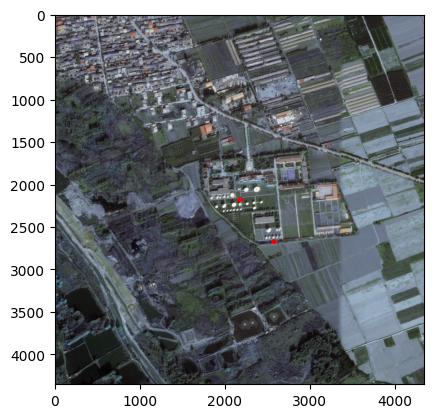

In [79]:

width, height = img.shape[1], img.shape[0]#kích thước ảnh

H = Point(width/2, height/2, 0.)
R = Point(width/2 + 400, height/2  +500, 0.)

color = (255, 0, 0)
radius =20
thickness = 20
imgCopy = img.copy()
imgCopy = cv2.circle(imgCopy,(int(R.x), int(R.y)), radius, color, thickness)
imgCopy = cv2.circle(imgCopy,(int(H.x), int(H.y)), radius, color, thickness)

plt.figure()
plt.imshow(imgCopy)

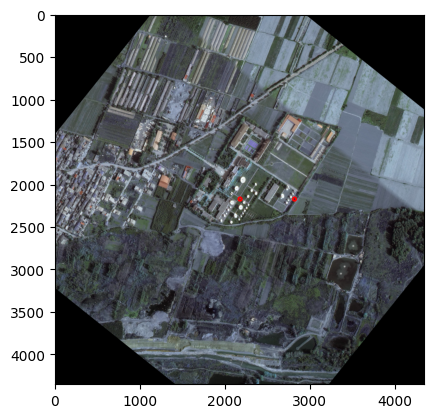

In [81]:

HR = H.vect(R)
# Trục Ox trái qua phải, Oy trên xuống dưới
Ox = Vect3D(np.array([1,0,0]))
Oy = Vect3D(np.array([0,1,0]))

cosX = HR.cos(Ox)
cosY = HR.cos(Oy)
# Xác định góc quay sao cho HR trùng với trục O
if cosY < 0:
    roto = 360 -  math.acos(cosX)*180/np.pi
else: roto = math.acos(cosX)*180/np.pi
# Xoay ảnh
M = cv2.getRotationMatrix2D((int(H.x), int(H.y)), roto, 1.0)
rotated = cv2.warpAffine(imgCopy, M, (img.shape[1], img.shape[0]))
                     
plt.figure()
plt.imshow(rotated)

In [82]:

# Cho tọa độ các điểm tương ứng của ảnh trong không gian. Coi ảnh nằm ở mặt phẳng z = 0
# h là độ cao của camera
h = 2000
A = Point(0,0,0.)
B = Point(0,height,0)
C = Point(width,height,0)
D = Point(width,0,0)
NewR = Point(abs(HR)+ width/2, height/2,0)
S = Point(width/2, height/2, -h) # z âm theo cách đặt trục Oz

$A^{'}$ là giao SA và mặt phẳng($\alpha$), vuông góc SR và đi qua R.  Hình ảnh trên ($\alpha$) là hình ảnh nhìn thấy từ camera theo tia SR

$\vec{RA^{'}} = \vec{RA} + t * \vec{RS}$

Phương trình mặt phẳng $\alpha$: $ \vec{SR} * \vec{RM} =0 $ $\forall M \in \alpha$ 

Thay $\vec{RA^{'}} = \vec{RA} + t*\vec{RS} \Rightarrow \vec{SR}* \vec{RA} + t * \vec{SR} * \vec{RS} = 0 \Rightarrow t =-\frac{\vec{RS} * \vec{RA}}{RS^2}$ 

In [83]:
def giaoDiem(S, R,A):
    RS = R.vect(S)
    RA = R.vect(A)
    t =  -(RS*RA)/(RS*RS)
#     print(t)
    return RA + RS*t
RA_ = giaoDiem(S,NewR,A)
RB_ = giaoDiem(S,NewR,B)
RC_ = giaoDiem(S,NewR,C)
RD_ = giaoDiem(S,NewR,D)
RA_, RB_,RC_,RD_

(Vect3D(-2554.478388882798, -2176.0, 817.8321242926928),
 Vect3D(-2554.478388882798, 2176.0, 817.8321242926928),
 Vect3D(1392.913901366635, 2176.0, -445.95003812489244),
 Vect3D(1392.913901366635, -2176.0, -445.95003812489244))

Đường thẳng l là giao mặt phẳng $\alpha$ và mặt phẳng gốc. Xét phép quay mặt phẳng $\alpha $ một góc $\theta$ sao cho $\alpha$ trùng với mặt phẳng gốc. Khi đó tọa độ ảnh của các vecto RA_, RB_, RC_, RD_ trên mặt phẳng gốc sẽ là tọa độ thực của các vecto RA, RB, RC,RD khi camera hướng vào điểm R.

Xử dụng công thức cho phep quay Rodrigues' rotation formula

In [85]:
kx, ky = 0.,-1. #vecto đơn vị của trục quay (đường thẳng l)
K = np.array([[0, 0, ky], [0,0, -kx],[-ky, kx, 0]])
I = np.diag(np.ones(3))
SH = S.vect(H)
SR = S.vect(NewR)
HR = H.vect(NewR)

cosTheta = abs(SH)/abs(SR)
sinTheta = abs(HR)/abs(SR)
#ma trận biến đổi của công thức Rodrigues
matrTransform = I + sinTheta*K + (1-cosTheta)*np.dot(K,K)
# Tim tọa độ ảnh trên mặt phẳng
def point(matr, srcVect, pointR = NewR):
    dstVect = Vect3D(np.dot(matr,srcVect.values))
    x= pointR.x + dstVect.values[0]
    y= pointR.y + dstVect.values[1]    
    z= pointR.z + dstVect.values[2]
    return Point(x,y,z)
A__ = point(matrTransform, RA_)
B__ = point(matrTransform, RB_)
C__ = point(matrTransform, RC_)
D__ = point(matrTransform, RD_)
A__,B__,C__,D__

(Point((134.11011541634707, 0.0, -4.323695498418335e-14)),
 Point((134.11011541634707, 4352.0, -4.323695498418335e-14)),
 Point((4278.872020178252, 4352.0, -2.5146549492182015e-14)),
 Point((4278.872020178252, 0.0, -2.5146549492182015e-14)))

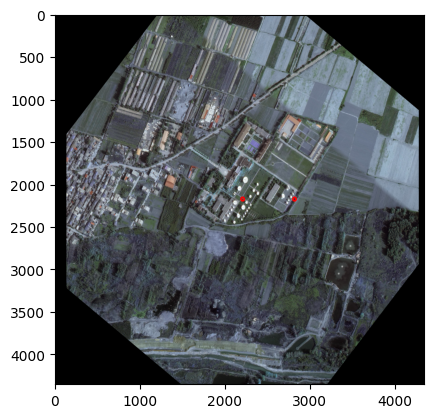

In [87]:
# Sau đó dùng warpPerspective để biến đổi ảnh gốc dựa theo biến đổi 4 điểm góc
input_pts = np.float32([[0,0], [0, height], [width,height], [width,0]])
output_pts = np.float32([[A__.x, A__.y],
                        [B__.x, B__.y],
                        [C__.x, C__.y],
                        [D__.x, D__.y]])
M = cv2.getPerspectiveTransform(input_pts,output_pts)
newSize = max(4352, int(A__.x), int(B__.x), int(C__.x), int(D__.x))

warp = cv2.warpPerspective(rotated,M,(newSize, newSize),flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(warp)

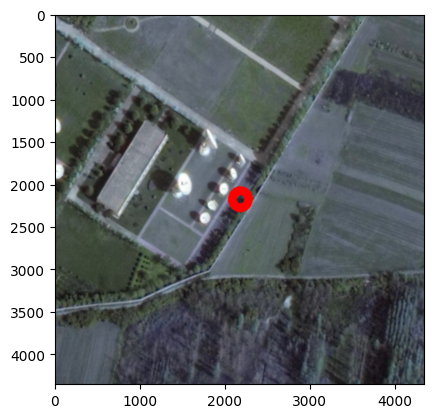

In [88]:
# Thay đổi tầm nhìn theo đô cao
def funcHeight(hNew, h, srcImg, centerPoint):
    width, height = img.shape[1], img.shape[0]
    scale = h/hNew
    oldWidth = int(width / scale)
    oldHeight = int(height /scale)
    if oldWidth % 2 == 1:oldWidth +=1
    if oldHeight%2 ==1: oldHeight +=1
    x0 = round(centerPoint.x)
    y0 = round(centerPoint.y)
    # Cắt một vùng có kích thước oldWidth x oldHeight với tâm là điểm R
    # Lấy hai điểm góc trái trên cùng và góc phải dưới cùng làm tiêu chuẩn
    leftPoint = [x0- oldWidth//2, y0 - oldHeight//2]
    rightPoint = [x0 + oldWidth//2, y0 + oldHeight//2]
    
    #Có thể xảy ra trường hợp tọa độ hai điểm này vượt ra ngoài kích thước ảnh srcImg,
    #Lúc này quan tâm tới các điểm pixel trên ảnh srcImg
    minY_src = max(leftPoint[1], 0)
    minX_src = max(leftPoint[0], 0)
    maxY_src = min(rightPoint[1], height)
    maxX_src = min(rightPoint[0], width)
    
    # ảnh mới với tâm là điểm R kích thước oldWidth x oldHeight
    dstImg = np.zeros((oldHeight, oldWidth, 3), dtype=np.uint8)

    
    #Những giá trị tương ứng trên ảnh dstImg so với srcImg
    minX_dst= max(0, -leftPoint[0])
    minY_dst= max(0, -leftPoint[1])
    maxX_dst = min(oldWidth, oldWidth - (rightPoint[0] - width))
    maxY_dst = min(oldHeight, oldHeight - (rightPoint[1] - height))
    
    dstImg[minY_dst:maxY_dst, minX_dst:maxX_dst] =srcImg[minY_src:maxY_src, minX_src: maxX_src]
    
    # resize
    result = cv2.resize(dstImg, (width, height), interpolation = cv2.INTER_LINEAR)
    return result
result = funcHeight(h/5, h, warp, NewR)
plt.figure()
plt.imshow(result)